In [307]:
import pandas as pd
import numpy as np
from datetime import date
import cpi
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
pd.set_option('display.max_columns', 500)

In [308]:
main_df = pd.read_csv(r'C:\Users\sfrie\Housetable\Recommender\price_prediction\Pricing_Model_dev\BATCH_API\data\MLS_Reggie\mls_tagged_with API.csv').drop(['Unnamed: 0'], axis = 1)

C:\Users\sfrie\AppData\Local\Temp\ipykernel_12328\2843832927.py:1: DtypeWarning: Columns (6,9,83,140,305,306,307,308,317,333,337,338,339,345,346,348,350,351,352,354,355,357,358,359,360,365) have mixed types. Specify dtype option on import or set low_memory=False.
  main_df = pd.read_csv(r'C:\Users\sfrie\Housetable\Recommender\price_prediction\Pricing_Model_dev\BATCH_API\data\MLS_Reggie\mls_tagged_with API.csv').drop(['Unnamed: 0'], axis = 1)


In [309]:
list(main_df.columns)

['full_address',
 'address',
 'street',
 'city',
 'state',
 'zip',
 'sold_month',
 'sold_day',
 'year_sold',
 '_id',
 'homeownerAssociations',
 'address.oldHashes',
 'address.houseNumber',
 'address.county',
 'address.zipPlus4',
 'address.localities',
 'address.hash',
 'address.latitude',
 'address.longitude',
 'address.normalized',
 'address.countyFipsCode',
 'address.formattedStreet',
 'address.streetNoUnit',
 'address.geoStatusCode',
 'address.geoStatus',
 'assessment.assessedImprovementValue',
 'assessment.assessedLandValue',
 'assessment.totalAssessedValue',
 'assessment.assessmentYear',
 'building.totalBuildingAreaSquareFeet',
 'building.totalBuildingAreaCode',
 'building.totalBuildingAreaCodeDescription',
 'building.yearBuilt',
 'building.effectiveYearBuilt',
 'building.buildingCount',
 'building.roomCount',
 'building.unitCount',
 'building.bedroomCount',
 'building.calculatedBathroomCount',
 'building.fullBathroomCount',
 'building.bathroomCount',
 'building.storyCode',
 'buil

In [310]:
df_dropped_na = main_df.dropna(subset = ['price_sold_tagged', 'full_address', 'year_sold', 'sold_month', 'sold_day', 'address', 'address.houseNumber', 'street', 'city',
        'state', 'zip', 'Bathroom_max_tagged',
 'Bathroom_min_tagged',
 'Bathroom_std_tagged',
 'Bathroom_mean_tagged',
 'Floor_max_tagged',
 'Floor_min_tagged',
 'Floor_std_tagged',
 'Floor_mean_tagged',
 'Walls_max_tagged',
 'Walls_min_tagged',
 'Walls_std_tagged',
 'Walls_mean_tagged',
 'Outview_tagged',
 'Outview_std_tagged',
 'Kitchen_level_tagged',
 'Kitchen_level_std_tagged'], axis = 0)
df_dropped_na.shape

(4377, 385)

In [311]:
from re import sub
from decimal import Decimal
def convert_money(x):
    try:
        return float(x)
    except:
        return Decimal(sub(r'[^\d.]', '', x))
df_dropped_na.price_sold_tagged = df_dropped_na.price_sold_tagged.apply(convert_money)

C:\Users\sfrie\AppData\Local\Temp\ipykernel_12328\3447556188.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dropped_na.price_sold_tagged = df_dropped_na.price_sold_tagged.apply(convert_money)


In [312]:
dub_addresses = df_dropped_na[df_dropped_na[['street']].duplicated(['street'])]['street']
dub_df = df_dropped_na.loc[df_dropped_na['street'].isin(dub_addresses)]
dub_df.shape

(3889, 385)

In [313]:
dub_df.head(3)

,full_address,address,street,city,state,zip,sold_month,sold_day,year_sold,_id,homeownerAssociations,address.oldHashes,address.houseNumber,address.county,address.zipPlus4,address.localities,address.hash,address.latitude,address.longitude,address.normalized,address.countyFipsCode,address.formattedStreet,address.streetNoUnit,address.geoStatusCode,address.geoStatus,assessment.assessedImprovementValue,assessment.assessedLandValue,assessment.totalAssessedValue,assessment.assessmentYear,building.totalBuildingAreaSquareFeet,building.totalBuildingAreaCode,building.totalBuildingAreaCodeDescription,building.yearBuilt,building.effectiveYearBuilt,building.buildingCount,building.roomCount,building.unitCount,building.bedroomCount,building.calculatedBathroomCount,building.fullBathroomCount,building.bathroomCount,building.storyCode,building.storyCount,building.storyCountDescription,building.garageParkingSpaceCount,building.residentialUnitCount,building.features,building.airConditioningSourceCode,building.airConditioningSource,building.buildingConditionCode,building.buildingCondition,building.buildingQualityCode,building.buildingQuality,building.constructionTypeCode,building.constructionType,building.exteriorWallsCode,building.exteriorWalls,building.heatSourceCode,building.heatSource,building.roofCoverCode,building.roofCover,building.roofTypeCode,building.roofType,building.styleCode,building.style,demographics.age,demographics.householdSize,demographics.income,demographics.netWorth,demographics.discretionaryIncome,demographics.genderCode,demographics.gender,demographics.millionaire,demographics.religiousAffiliationCode,demographics.religiousAffiliation,demographics.individualEducationCode,demographics.individualEducation,demographics.recentlyMoved,demographics.recentlyMovedMonth,demographics.recentlyMovedYear,general.primaryParcel,general.parcelCount,general.vacant,general.mailingAddressVacant,general.standardizedLandUseCode,general.propertyTypeCategory,general.propertyTypeDetail,general.congressionalDistrict,general.timeZone,general.utcOffset,general.daylightSavingsTime,general.carrierRoute,general.censusTract,general.schoolDistrict,ids.addressHash,ids.apn,ids.quantariumUrn,ids.fipsCode,ids.personIds,involuntaryLien.liens,legal.legalDescription,legal.lotNumber,legal.cityTownshipMunicipality,legal.tractNumber,lot.lotSizeAcres,lot.lotDepthFeet,lot.lotFrontageFeet,lot.lotSizeSquareFeet,lot.zoningCode,lot.estimatedLotSizeSquareFeet,mls.mlsNumber,mls.status,mls.price,mls.daysOnMarket,mls.originalListingDate,mls.initialListingStatus,mls.statusSubtype,mls.rentalIndicator,mls.maxListPrice,mls.maxListPriceDate,mls.minListPrice,mls.minListPriceDate,mls.soldPrice,mls.soldDate,mls.bedroomCount,mls.bathroomCount,mls.buildingStyle,mls.totalBuildingAreaSquareFeet,mls.lotSizeSquareFeet,mls.floorCount,mls.propertyType,mls.appliances,mls.coolingTypes,mls.heatingTypes,mls.agentOffices,mls.schools,mls.agents,openLien.mortgages,owner.fullName,owner.mailingAddress.houseNumber,owner.mailingAddress.street,owner.mailingAddress.city,owner.mailingAddress.county,owner.mailingAddress.state,owner.mailingAddress.zip,owner.mailingAddress.formattedStreet,owner.mailingAddress.streetNoUnit,owner.mailingAddress.hash,owner.names,owner.ownerOccupied,owner.ownerStatusType,owner.lengthOfResidenceMonths,owner.ownershipStartDate,quickLists.absenteeOwner,quickLists.absenteeOwnerInState,quickLists.absenteeOwnerOutOfState,quickLists.activeListing,quickLists.activeAuction,quickLists.bankruptcy,quickLists.cashBuyer,quickLists.corporateOwned,quickLists.divorce,quickLists.expiredListing,quickLists.freeAndClear,quickLists.highEquity,quickLists.inherited,quickLists.liens,quickLists.listedBelowMarketPrice,quickLists.lowEquity,quickLists.mailingAddressVacant,quickLists.noticeOfDefault,quickLists.onMarket,quickLists.outOfStateOwner,quickLists.ownerOccupied,quickLists.pendingListing,quickLists.preforeclosure,quickLists.recentlySold,quickLists.samePropertyAndMailingAddress,quickLists.taxDefault,qui

Group By's (condition differences, price differences) To validate that there is deviation

In [314]:
dub_df.groupby(['street'])[['Bathroom_max_tagged',
 'Bathroom_min_tagged',
 'Bathroom_std_tagged',
 'Bathroom_mean_tagged',
 'Floor_max_tagged',
 'Floor_min_tagged',
 'Floor_std_tagged',
 'Floor_mean_tagged',
 'Walls_max_tagged',
 'Walls_min_tagged',
 'Walls_std_tagged',
 'Walls_mean_tagged',
 'Outview_tagged',
 'Outview_std_tagged']].std()

,Bathroom_max_tagged,Bathroom_min_tagged,Bathroom_std_tagged,Bathroom_mean_tagged,Floor_max_tagged,Floor_min_tagged,Floor_std_tagged,Floor_mean_tagged,Walls_max_tagged,Walls_min_tagged,Walls_std_tagged,Walls_mean_tagged,Outview_tagged,Outview_std_tagged
street,,,,,,,,,,,,,,
1001 w 132nd st,1.414214,0.000000,0.707107,0.707107,1.414214,0.000000,0.000000,0.707107,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10013 westwanda dr,0.000000,0.000000,0.000000,0.707107,0.000000,0.000000,0.000000,0.707107,0.000000,0.000000,0.000000,0.707107,0.707107,0.000000
10032 pangborn ave,2.121320,0.707107,0.707107,1.414214,0.000000,0.000000,0.000000,0.000000,1.414214,0.000000,0.000000,0.707107,0.000000,0.707107
10033 la reina ave,0.000000,1.414214,0.707107,0.707107,1.414214,0.000000,0.707107,0.000000,0.000000,0.707107,0.000000,0.707107,0.707107,0.000000
10037 beach st,0.707107,1.414214,0.707107,0.000000,0.000000,0.707107,0.707107,0.000000,1.414214,0.707107,0.707107,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9900 haledon ave,0.000000,1.414214,0.000000,0.000000,0.000000,0.000000,0.707107,0.000000,0.000000,0.000000,0.000000,0.707107,0.000000,0.000000
991 arapahoe st 504a,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.414214,0.707107,0.707107,0.707107,0.000000,0.000000
9916 potter st,0.707107,1.414214,0.000000,0.707107,1.414214,0.707107,0.000000,0.707107,0.000000,0.707107,0.000000,0.000000,0.000000,0.000000


In [315]:
# d = pd.DataFrame(columns= ['condition', 'level'])
# d.append({'condition': 5, 'level': 3}, ignore_index= True)


In [316]:
columns = ['full_address', 'address', 'sale_between', 'Bathroom_max_tagged',
 'Bathroom_min_tagged',
 'Bathroom_std_tagged',
 'Bathroom_mean_tagged',
 'Floor_max_tagged',
 'Floor_min_tagged',
 'Floor_std_tagged',
 'Floor_mean_tagged',
 'Walls_max_tagged',
 'Walls_min_tagged',
 'Walls_std_tagged',
 'Walls_mean_tagged',
 'Outview_tagged',
 'Outview_std_tagged',
 'Kitchen_level_tagged',
 'Kitchen_level_std_tagged','overall_condition']

aggregation_columns = ['Bathroom_max_tagged',
 'Bathroom_min_tagged',
 'Bathroom_std_tagged',
 'Bathroom_mean_tagged',
 'Floor_max_tagged',
 'Floor_min_tagged',
 'Floor_std_tagged',
 'Floor_mean_tagged',
 'Walls_max_tagged',
 'Walls_min_tagged',
 'Walls_std_tagged',
 'Walls_mean_tagged',
 'Outview_tagged',
 'Outview_std_tagged',
 'Kitchen_level_tagged',
 'Kitchen_level_std_tagged',
 'overall_condition']
 
difference_df = pd.DataFrame(columns = columns)

In [317]:
dub_df['overall_condition'] = np.mean(dub_df[['Kitchen_level_tagged', 'Floor_mean_tagged', 'Walls_mean_tagged', 'Outview_tagged', 'Bathroom_mean_tagged']], axis = 1)


C:\Users\sfrie\AppData\Local\Temp\ipykernel_12328\792075468.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dub_df['overall_condition'] = np.mean(dub_df[['Kitchen_level_tagged', 'Floor_mean_tagged', 'Walls_mean_tagged', 'Outview_tagged', 'Bathroom_mean_tagged']], axis = 1)


In [319]:
list_of_data = []
for house in dub_df['street'].unique():
    house_df = dub_df[dub_df['street'] == house]
    for i, sale_a in house_df.iterrows():
        # print(i)
        # print(sale_a['street'])
        for j, sale_b in house_df.iterrows():
            if j == i: # If Sale_a == Sale_b (don't want the model to predict against itself. Or do we?)
                continue
            data_point = dict()
            data_point['full_address'] = sale_a['full_address']
            data_point['street'] = house
            data_point['sale_between'] = ''.join([str(sale_a['year_sold']), '_', str(sale_b['year_sold'])])
            data_point['sale_a'] = sale_a['year_sold']
            data_point['sale_b'] = sale_b['year_sold']
            # data_point['time_between_sales'] = int(sale_a['year_sold']) - int(sale_b['year_sold']) #Need to fix in pre-processing

            # print(data_point['sale_between'])
            data_point['price_difference'] = int(float(sale_a['price_sold_tagged'])) - int(float(sale_b['price_sold_tagged']))
            # print(data_point['price_difference'])
            for col in aggregation_columns:
                data_point[col] = int(sale_a[col]) - int(sale_b[col])
            list_of_data.append(data_point)
    
difference_df = pd.DataFrame.from_records(list_of_data)


In [320]:
difference_df.head(10)

,full_address,street,sale_between,sale_a,sale_b,price_difference,overall_condition
0,"3913 York Boulevard, Los Angeles, CA 90065 Sol...",3913 york blvd,2021_2019,2021,2019,305000,0
1,"3913 York Boulevard, Los Angeles, CA 90065 Sol...",3913 york blvd,2019_2021,2019,2021,-305000,0
2,"4171 Division Street, Los Angeles, CA 90065 So...",4171 division st,2020_2015,2020,2015,225000,0
3,"4171 Division Street, Los Angeles, CA 90065 So...",4171 division st,2015_2020,2015,2020,-225000,0
4,"4234 PALMERO Drive, Los Angeles, CA 90065 Sold...",4234 palmero dr,2017_2020,2017,2020,-416000,0
5,"4234 Palmero Drive, Los Angeles, CA 90065 Sold...",4234 palmero dr,2020_2017,2020,2017,416000,0
6,"4237 Caledonia Way, Los Angeles, CA 90065 Sold...",4237 caledonia way,2019_2021,2019,2021,-452000,0
7,"4237 Caledonia Way, Los Angeles, CA 90065 Sold...",4237 caledonia way,2021_2019,2021,2019,452000,0
8,"4613 Jessica Drive, Los Angeles, CA 90065 Sold...",4613 jessica dr,2021_2009,2021,2009,665000,0
9,"4613 Jessica Drive, Los Angeles, CA 90065 Sold...",4613 jessica dr,2009_2021,2009,2021,-665000,0


In [321]:
difference_df.shape

(4124, 7)

In [322]:
difference_df = difference_df.merge(dub_df, how = 'left', on = 'full_address', suffixes= ('', '_b'))

### Modeling

In [359]:
address = ['address.houseNumber', 'street', 'city',
        'state', 'zip', 'address.zipPlus4',
       ] #'address.latitude', 'address.longitude'

continuous = [ 'building.totalBuildingAreaSquareFeet',
       # 'building.unitCount',
       #  'building.calculatedBathroomCount', 'building.bathroomCount',
       'building.fullBathroomCount', 
       'lot.lotDepthFeet', 'lot.lotSizeSquareFeet',
       'building.storyCount', 'mls.floorCount',   
       'building.buildingQualityCode', 'building.garageParkingSpaceCount',

 'bedrooms_tagged',
 'bathrooms_tagged',
#  'living_area_tagged',
#  'year_built_tagged',
 'Bathroom_max_tagged',
 'Bathroom_min_tagged',
 'Bathroom_std_tagged',
 'Bathroom_mean_tagged',
 'Floor_max_tagged',
 'Floor_min_tagged',
 'Floor_std_tagged',
 'Floor_mean_tagged',
 'Walls_max_tagged',
 'Walls_min_tagged',
 'Walls_std_tagged',
 'Walls_mean_tagged', 
 'Outview_tagged',
 'Outview_std_tagged',
#  's_tagged',
 'Kitchen_level_tagged',
 'Kitchen_level_std_tagged',
 'overall_condition'] #'lot.lotSizeAcres', 'building.roomCount', 'lot.lotFrontageFeet', 'building.garageParkingSpaceCount',

    
#Notes: Need to reverse the ordinality of the buildingQualityCode

ordinal = ['general.propertyTypeDetail'] 


one_hot = ['building.styleCode',  'sub_type_tagged'] # 'building.roofCover', 'building.garageCode'
  #'mls.coolingTypes','building.features' 'mls.exteriorConstruction', 'building.styleCode' 'mls.roofTypes','airConditioningSource',  
  #'airConditioningSourceCode', 'interiorWallsCode', 'floorCoverCode', 'garageCode', 'heatSourceCode', 'patioCode' , 'porchCode', 'roofCoverCode, 'styleCode'

target = ['price_difference']
target_year = ['sale_a']
# assessments = ['sale.priorSale.price', 'assessment.totalAssessedValue'] #Assessment imprvoed, assessment land
#Assessment year MUST BE the first entryy in the list
years = ['assessment.assessmentYear','sale.lastSale.saleDate', 'sale.priorSale.saleDate', 'building.yearBuilt', 'sale_a', 'sale_b'] #BuildingYearBuilt  MUST BE the last entryy in the list
# price_year_pairings = [('sale.lastSale.price', 'sale.lastSale.saleDate'), ('assessment.totalAssessedValue', 'assessment.assessmentYear'), ('sale.priorSale.price', 'sale.priorSale.saleDate')]
price_year_pairings = [('price_difference', 'sale_a')]

# to_sparse = ['building.features']

not_sure = [ 'building.heatSourceCode'] #OneHot? What to do with new values?

features_not_in_single = ['mls.totalBuildingAreaSquareFeet', 'mls.lotSizeSquareFeet', 'building.residentialUnitCount', 'building.buildingQualityCode', 'building.buildingQuality', 
'building.constructionTypeCode', 'building.constructionType', 'mls.daysOnMarket', 'mls.maxListPrice', 'mls.maxListPriceDate', 'mls.minListPrice', 'mls.minListPriceDate', 'mls.soldPrice', 'mls.soldDate', 'mls.bedroomCount', 'mls.bathroomCount', 'mls.floorCount',
'mls.propertyType', 'mls.appliances', 'sale.priorSale.price', 'sale.priorSale.saleDate']

In [360]:
# features = [address, continuous, ordinal, assessments, years, target, one_hot, to_sparse, not_sure]
features = [address, continuous, ordinal, years, target, one_hot, not_sure]


In [361]:
features
features = [x for y in features for x in y]

In [362]:
print( f' df rows: {main_df.shape[0]}, columns: {len(features)}')

 df rows: 4738, columns: 44


In [363]:
df = difference_df.loc[:, features]

In [364]:
# df.dropna(subset = ['sale.lastSale.price'], inplace= True)

In [365]:
df.shape[0]

4154

# Impute/Pre-Process

In [366]:
df.replace('nan', np.nan, inplace = True)

In [367]:
df.columns

Index(['address.houseNumber', 'street', 'city', 'state', 'zip',
       'address.zipPlus4', 'building.totalBuildingAreaSquareFeet',
       'building.fullBathroomCount', 'lot.lotDepthFeet',
       'lot.lotSizeSquareFeet', 'building.storyCount', 'mls.floorCount',
       'building.buildingQualityCode', 'building.garageParkingSpaceCount',
       'bedrooms_tagged', 'bathrooms_tagged', 'Bathroom_max_tagged',
       'Bathroom_min_tagged', 'Bathroom_std_tagged', 'Bathroom_mean_tagged',
       'Floor_max_tagged', 'Floor_min_tagged', 'Floor_std_tagged',
       'Floor_mean_tagged', 'Walls_max_tagged', 'Walls_min_tagged',
       'Walls_std_tagged', 'Walls_mean_tagged', 'Outview_tagged',
       'Outview_std_tagged', 'Kitchen_level_tagged',
       'Kitchen_level_std_tagged', 'overall_condition',
       'general.propertyTypeDetail', 'assessment.assessmentYear',
       'sale.lastSale.saleDate', 'sale.priorSale.saleDate',
       'building.yearBuilt', 'sale_a', 'sale_b', 'price_difference',
       'build

In [368]:
df.loc[:, target]

,price_difference
0,305000
1,-305000
2,225000
3,-225000
4,-416000
...,...
4149,-154900
4150,225000
4151,-225000
4152,-55000


#### Fill missing values-- Fill with mls features, or Vice-Versa

In [369]:
df.loc[:, 'mls.floorCount'].fillna(df.loc[:, 'building.storyCount'], inplace = True)
df.drop(['building.storyCount'], axis = 1, inplace = True)

#### Fix "Year" Features

In [370]:
df

,address.houseNumber,street,city,state,zip,address.zipPlus4,building.totalBuildingAreaSquareFeet,building.fullBathroomCount,lot.lotDepthFeet,lot.lotSizeSquareFeet,mls.floorCount,building.buildingQualityCode,building.garageParkingSpaceCount,bedrooms_tagged,bathrooms_tagged,Bathroom_max_tagged,Bathroom_min_tagged,Bathroom_std_tagged,Bathroom_mean_tagged,Floor_max_tagged,Floor_min_tagged,Floor_std_tagged,Floor_mean_tagged,Walls_max_tagged,Walls_min_tagged,Walls_std_tagged,Walls_mean_tagged,Outview_tagged,Outview_std_tagged,Kitchen_level_tagged,Kitchen_level_std_tagged,overall_condition,general.propertyTypeDetail,assessment.assessmentYear,sale.lastSale.saleDate,sale.priorSale.saleDate,building.yearBuilt,sale_a,sale_b,price_difference,building.styleCode,sub_type_tagged,building.heatSourceCode
0,3913,3913 york blvd,los angeles,ca,90065,3718,1121.0,2.0,800.0,4381.0,1.0,1.0,2.0,2.0,2.0,5.0,2.0,1.0,4.0,5.0,2.0,1.0,4.0,5.0,2.0,1.0,5.0,2.0,1.0,4.0,0.0,0,Single Family,2021,2021-04-19T00:00:00.000Z,2019-05-09T00:00:00.000Z,1939.0,2021,2019,305000,15.0,S,3.0
1,3913,3913 york blvd,los angeles,ca,90065,3718,1121.0,2.0,800.0,4381.0,1.0,1.0,2.0,2.0,2.0,4.0,2.0,1.0,3.0,5.0,2.0,1.0,3.0,5.0,2.0,1.0,4.0,2.0,1.0,4.0,1.0,0,Single Family,2021,2021-04-19T00:00:00.000Z,2019-05-09T00:00:00.000Z,1939.0,2019,2021,-305000,15.0,S,3.0
2,4171,4171 division st,los angeles,ca,90065,4205,1250.0,1.0,890.0,5103.0,1.0,7.0,1.0,2.0,2.0,5.0,2.0,1.0,4.0,5.0,2.0,1.0,4.0,5.0,2.0,1.0,4.0,2.0,1.0,4.0,0.0,0,Single Family,2021,2020-11-23T00:00:00.000Z,2015-06-19T00:00:00.000Z,1947.0,2020,2015,225000,15.0,S,6.0
3,4171,4171 division st,los angeles,ca,90065,4205,1250.0,1.0,890.0,5103.0,1.0,7.0,1.0,2.0,2.0,5.0,2.0,1.0,4.0,5.0,2.0,1.0,4.0,5.0,2.0,1.0,3.0,2.0,0.0,4.0,0.0,0,Single Family,2021,2020-11-23T00:00:00.000Z,2015-06-19T00:00:00.000Z,1947.0,2015,2020,-225000,15.0,S,6.0
4,4234,4234 palmero dr,los angeles,ca,90065,4251,1258.0,2.0,1100.0,8012.0,1.0,9.0,2.0,2.0,2.0,5.0,2.0,1.0,4.0,5.0,2.0,1.0,4.0,5.0,2.0,1.0,4.0,2.0,1.0,4.0,1.0,0,Single Family,2021,2020-09-01T00:00:00.000Z,2017-02-09T00:00:00.000Z,1955.0,2017,2020,-416000,15.0,S,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4149,2013,2013 n corlett ave,los angeles,ca,90059,3626,1796.0,2.0,1000.0,5003.0,1.0,1.0,NaN,2.0,1.0,5.0,1.0,1.0,4.0,3.0,2.0,1.0,3.0,3.0,2.0,1.0,3.0,2.0,1.0,4.0,0.0,1,Single Family,2021,2017-04-18T00:00:00.000Z,2016-12-19T00:00:00.000Z,1945.0,2016,2017,-154900,NaN,S,6.0
4150,2307,2307 e 120th st,los angeles,ca,90059,2629,753.0,1.0,2100.0,12186.0,1.0,8.0,NaN,2.0,1.0,4.0,4.0,0.0,4.0,3.0,2.0,1.0,2.0,3.0,2.0,1.0,2.0,3.0,1.0,4.0,0.0,0,Single Family,2021,2021-07-26T00:00:00.000Z,2016-08-25T00:00:00.000Z,1915.0,2021,2016,225000,NaN,S,NaN
4151,2307,2307 e 120th st,los angeles,ca,90059,2629,753.0,1.0,2100.0,12186.0,1.0,8.0,NaN,2.0,1.0,4.0,2.0,1.0,3.0,5.0,3.0,1.0,4.0,3.0,2.0,1.0,3.0,2.0,1.0,4.0,0.0,0,Single Family,2021,2021-07-26T00:00:00.000Z,2016-08-25T00:00:00.000Z,1915.0,2016,2021,-225000,NaN,S,NaN
4152,11709,11709 compton ave,los angeles,ca,90059,1826,744.0,1.0,870.0,2175.0,1.0,7.0,NaN,2.0,1.0,5.0,2.0,1.0,3.0,3.0,2.0,1.0,2.0,3.0,2.0,1.0,3.0,2.0,0.0,4.0,0.0,-1,Single Family,2021,2017-07-06T00:00:00.000Z,2017-03-20T00:00:00.000Z,1927.0,2017,2017,-55000,15.0,S,6.0


In [371]:
current_year = int(date.today().year)

df.sale_a = df.sale_a.astype(str).str.replace('-', '')
df.sale_b = df.sale_b.astype(str).str.replace('-', '')
df.loc[df['sale_a'].astype(int) > current_year, 'sale_a'] = current_year
df.loc[df['sale_b'].astype(int) > current_year, 'sale_b'] = current_year
df.loc[df['sale_a'].astype(int) < current_year, 'sale_a'] = current_year
df.loc[df['sale_b'].astype(int) < current_year, 'sale_b'] = current_year


In [372]:
def take_year(x):
    x = x.split('-')
    x = int(x[0])
    return x
    
for year in years:
    print(year)
    
    try:
        
        df[year] = df[year].fillna(df[year].mode()[0])
        df[year].astype(float).astype(int) #Check to see if its numerical already.
        df.loc[:, year] = df.loc[:, year].astype(int)
    except:
        df[year] = df[year].fillna(df[year].mode()[0]) #If not numerical, than apply the take_year function
        df[year] = df[year].apply(take_year)
        df.loc[:, year].astype(int)
        # df[df[year] > current_year] = current_year


assessment.assessmentYear
sale.lastSale.saleDate
sale.priorSale.saleDate
building.yearBuilt
sale_a
sale_b


In [373]:
#Apply current price adjusted for inflation
def apply_cpi(x, price_col, year_col):
    price = x.loc[price_col]
    year = x.loc[year_col]
    if year != current_year:
        val = cpi.inflate(price, int(year))
        x.loc[price_col] = val
    return x

# df = df.apply(apply_cpi, args = ('sale.lastSale.price', 'sale.lastSale.saleDate'), axis = 1)
# df = df.apply(apply_cpi, args = ('assessment.totalAssessedValue', 'assessment.assessmentYear'), axis = 1)
for pair in price_year_pairings:
    df = df.apply(apply_cpi, args = (pair), axis =1)

In [374]:
# c = df.select_dtypes(object).columns
# df[c] = df[c].apply(pd.to_numeric,errors='coerce')

### House Features

In [375]:
# houses_features = []
# a = df.loc[:,to_sparse].values
# for x in a:
#     features_dict = {'AC': 0, 'Fireplace': 0, 'SolarHeat': 0, 'EvaporativeCooler': 0, 'AttachedGarage': 0, 'SpaorHotTub': 0, 'Spa': 0, 'Pool': 0, 'Garage': 0}
#     for y in x:
#         attr = y.replace("[", "").replace("]", "").replace("'", "").replace(" ", "").split(",")
#         for item in attr:
#             if "Conditioning" in item:
#                 if "Wall" in item:
#                     features_dict['AC'] = 1
#                 elif "Central" in item:
#                     features_dict['AC'] = 3
#                 else:
#                     features_dict['AC'] = 2
#             else:
#                 features_dict[item] = 1
#     houses_features.append(features_dict)
# features_df = pd.DataFrame(houses_features)
# df = df.join(features_df).drop(['building.features'], axis = 1)

## Feature Engineering

Average Price per Zip

In [376]:
df['has_garage'] = df['building.garageParkingSpaceCount'].apply(lambda x: 1 if x > 0 else 0)

In [377]:
df = df.merge(df.groupby('zip')[target[0]].mean(), on = 'zip', suffixes= ('','_y'))
df.rename(columns = {f'{target[0]}_y': 'average_zip_price'},  inplace= True,  )

In [378]:
df['age'] = df[target_year[0]] - df['building.yearBuilt']

In [379]:
df['time_between_sales'] = df['sale_a'] - df['sale_b']

In [380]:
df = pd.get_dummies(df, columns= one_hot)

Ordinal Encoding

In [381]:
from sklearn.preprocessing import OrdinalEncoder
# df.loc[:, ordinal] = ord.fit_transform(df['building.buildingQualityCode'].values.reshape(len(df['building.buildingQualityCode']), 1))
ord_encoders = {}
for col in ordinal:
    ord = OrdinalEncoder(handle_unknown= 'use_encoded_value', unknown_value= len(df[col]) +1)
    ord_encoders[col] = ord
    df[col] = ord.fit_transform(df[col].values.reshape(len(df[col]), 1))

# for col in ordinal:
#     df[col] = ord_encoders[col].transform(df[col])

Outlier Removal

In [382]:
# from scipy import stats
# # statcols = ['sqft','living_area','hc_details_assessment_total_assessed_value']
# df['statcol'] = df['sale.lastSale.price'] - df['assessment.totalAssessedValue']
# statcols = ['statcol']
# abs_z_scores = np.abs(stats.zscore(df[statcols]))
# filtered_entries = (abs_z_scores < 3).all(axis=1)
# train = df[filtered_entries]
# train.drop(['statcol'], axis = 1, inplace = True)

In [383]:
import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
df.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in df.columns.values]


In [384]:
df.columns

Index(['address.houseNumber', 'street', 'city', 'state', 'zip',
       'address.zipPlus4', 'building.totalBuildingAreaSquareFeet',
       'building.fullBathroomCount', 'lot.lotDepthFeet',
       'lot.lotSizeSquareFeet', 'mls.floorCount',
       'building.buildingQualityCode', 'building.garageParkingSpaceCount',
       'bedrooms_tagged', 'bathrooms_tagged', 'Bathroom_max_tagged',
       'Bathroom_min_tagged', 'Bathroom_std_tagged', 'Bathroom_mean_tagged',
       'Floor_max_tagged', 'Floor_min_tagged', 'Floor_std_tagged',
       'Floor_mean_tagged', 'Walls_max_tagged', 'Walls_min_tagged',
       'Walls_std_tagged', 'Walls_mean_tagged', 'Outview_tagged',
       'Outview_std_tagged', 'Kitchen_level_tagged',
       'Kitchen_level_std_tagged', 'overall_condition',
       'general.propertyTypeDetail', 'assessment.assessmentYear',
       'sale.lastSale.saleDate', 'sale.priorSale.saleDate',
       'building.yearBuilt', 'sale_a', 'sale_b', 'price_difference',
       'building.heatSourceCode', 'h

#### Columns to Drop: Keep Assement Values or Not

In [385]:
# df = df.drop(assessments, axis = 1) #Drop all assements
# df = df.drop('assessment.totalAssessedValue', axis = 1)
# df = df.drop('sale.priorSale.price', axis = 1)

#### Train Test Split: Keep House Groupings, or Randomize

In [386]:
# Y = df.loc[:, target[0]]
# train_df = df.drop([ 'zip', 'address.zipPlus4', 'address.houseNumber', 'street', 'city', 'state'], axis = 1)
# train_df = train_df.drop(years, axis = 1)
# train_df = train_df.drop(target[0], axis = 1)


# # train_df = train.drop([target[0], 'zip_code', 'address.zipPlus4'], axis = 1)
# # train.columns = range(len(train.columns))

# x_train, x_val, y_train, y_val = train_test_split(train_df, Y, test_size= 0.2, random_state= 7)

# xgb = XGBRegressor( eta = 0.003, max_depth = 2, n_estimators = 800, colsample_bytree = 1)
# xgb.fit(x_train, y_train)
# pred = xgb.predict(x_val)
# np.sqrt(mean_squared_error(pred, y_val))

In [387]:
# Y = df.loc[:, target[0]]
np.random.seed(7)

df = df.drop([ 'zip', 'address.zipPlus4', 'address.houseNumber', 'street', 'city', 'state'], axis = 1)
df = df.drop(years, axis = 1)

x_pos = df[df['price_difference'] > 0].sample(frac = 0.2, random_state = 7)
x_rest = df[~df.index.isin(x_pos.index)]

y_val = x_pos.loc[:, target[0]]
y_train = x_rest.loc[:, target[0]]

x_val = x_pos.drop(target[0], axis = 1)
x_train = x_rest.drop(target[0], axis = 1)

from xgboost import XGBRegressor
# from sklearn.model_selection import train_val_split
from sklearn.metrics import mean_squared_error


In [388]:
xgb = XGBRegressor(max_depth = 4, n_estimators = 300, colsample_bytree = 1)
xgb.fit(x_train, y_train)
pred = xgb.predict(x_val)
np.sqrt(mean_squared_error(pred, y_val))

c:\Users\sfrie\miniconda3\envs\Pricing_Models\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


252036.69689156357

In [389]:
x_val_1 = x_val.copy()
x_val_5 = x_val.copy()
x_val_1.Bathroom_min_tagged = 1
x_val_1.Bathroom_max_tagged = 1
x_val_1.Bathroom_mean_tagged = 1
x_val_1.Bathroom_std_tagged = 0


x_val_5.Bathroom_min_tagged = 5
x_val_5.Bathroom_max_tagged = 5
x_val_5.Bathroom_mean_tagged = 5
x_val_5.Bathroom_std_tagged = 0
a = np.round(xgb.predict(x_val_5) - xgb.predict(x_val_1))
a.mean()

25916.371

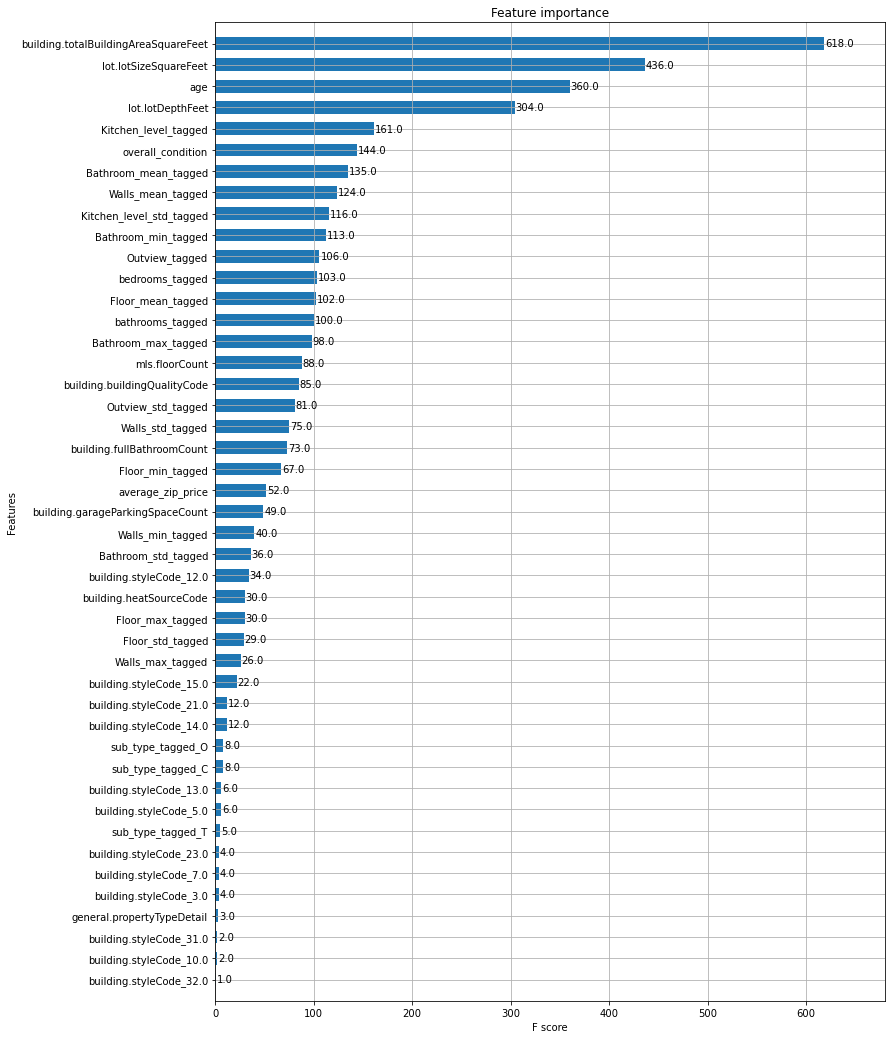

In [390]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,18))
plot_importance(xgb, max_num_features=50, height=0.6, ax=ax)

plt.show()

#### Testing Importance of the Features

In [391]:
x_val_1 = x_val.copy()
x_val_5 = x_val.copy()
x_val_1.Bathroom_min_tagged = 1
x_val_1.Bathroom_max_tagged = 1
x_val_1.Bathroom_mean_tagged = 1
x_val_1.Bathroom_std_tagged = 0


x_val_5.Bathroom_min_tagged = 5
x_val_5.Bathroom_max_tagged = 5
x_val_5.Bathroom_mean_tagged = 5
x_val_5.Bathroom_std_tagged = 0
a = np.round(xgb.predict(x_val_5) - xgb.predict(x_val_1))
a.mean()

25916.371

171
239
